In [248]:
import numpy as np
import pandas as pd
import gzip
import torch
from torch.optim import Adagrad,Adam
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.metrics import mean_squared_error
from deepctr_torch.inputs import SparseFeat, get_feature_names
from deepctr_torch.models import DeepFM

In [249]:
def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        try:
            yield eval(l)
        except:
            pass

def convert_height(x):
  '''
  convert hight from feet-inches format to cm
  if nan, return 165
  '''
  try:
    h_ft,temp = x.split("'")
    h_inch,_ = temp.split('"')
    #print(h_inch,h_ft)
    h_inch = float(h_inch)
    h_ft = float(h_ft)
    h_inch += h_ft * 12
    h_cm = round(h_inch * 2.54, 1)
  except:
    h_cm = 165
  return h_cm

def import_data(path):
  '''
  import data and convert to pandas dataframe
  '''
  data_dict = list(parse(path))
  data = pd.DataFrame(data_dict)
  print(len(data))
  return data

def feature_transformation(data):
  '''
  applying feature_transformation to dense features
  1. convert weight to numeric
  2. convert height to cm
  2. bucketing all numeric features
  '''
  data['weight'] = data['weight'].str.replace('lbs','')
  data['height'] = data.height.apply(lambda row: convert_height(row))
  # data['fit'] = data['fit'].str.replace('fit','1')
  # data['fit'] = data['fit'].str.replace('small','0')
  # data['fit'] = data['fit'].str.replace('large','0')
  data[["weight", "age","rating"]] = data[["weight", "age","rating"]].apply(pd.to_numeric)
  data['age'] = pd.cut(data.age,bins=[0,2,17,65,99],labels=['Toddler/Baby','Child','Adult','Elderly'])
  data['weight'] = pd.cut(data.weight,bins=[0,50,125,200],labels=['low','medium','high'])
  data['size'] = pd.cut(data['size'],bins=[0,15,30,60],labels=['low','medium','high'])
  data['height'] = pd.cut(data['height'],bins=[0,169,185,200],labels=['low','medium','high'])
  return data

In [262]:
data_original = import_data('renttherunway_final_data.json.gz') # import data as pandas dataframe
#data = feature_transformation(data_original) # applying feature transformation
data.head()

192462


,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date
0,fit,420272,34d,2260466,high,10,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,medium,low,Adult,"April 20, 2016"
1,fit,273551,34b,153475,high,10,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,low,low,Adult,"June 18, 2013"
2,fit,360448,NaN,1063761,NaN,10,party,This hugged in all the right places! It was a ...,NaN,It was a great time to celebrate the (almost) ...,sheath,low,low,NaN,"December 14, 2015"
3,fit,909926,34c,126335,high,8,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,low,low,Adult,"February 12, 2014"
4,fit,151944,34b,616682,high,10,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,medium,low,Adult,"September 26, 2016"


In [266]:
data.rating.count()

192462

(array([  1046.,      0.,   2791.,      0.,      0.,  10697.,      0.,
         53391.,      0., 124537.]),
 array([ 2. ,  2.8,  3.6,  4.4,  5.2,  6. ,  6.8,  7.6,  8.4,  9.2, 10. ]),
 <a list of 10 Patch objects>)

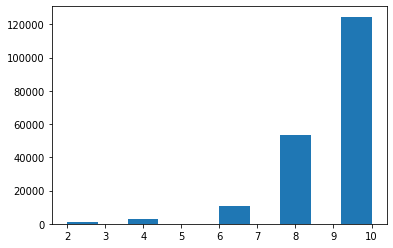

In [268]:
# visualize data distributioon
# data['rating'] = np.log(data['rating']+2)
# data[['rating','weight']]=scaler.transform(data[['rating','weight']])
import matplotlib.pyplot as plt
data_original['weight'] = data_original['weight'].str.replace('lbs','')

plt.hist(data['rating'], density=False, bins=10)

# DeepFM

In [242]:
# using PyTorch version of DeepCTR
def train_deepFM():
  sparse_features = ["item_id", "user_id",
                  "age", "size", "weight",'bust size','height','category','fit']
  target = ['rating']

  # 1.Label Encoding for sparse features,and do simple Transformation for dense features
  for feat in sparse_features:
      lbe = LabelEncoder()
      data[feat] = lbe.fit_transform(data[feat])
  # 2.count #unique features for each sparse field
  fixlen_feature_columns = [SparseFeat(feat, data[feat].nunique())
                            for feat in sparse_features]
  linear_feature_columns = fixlen_feature_columns[:2]
  dnn_feature_columns = fixlen_feature_columns[2:]
  feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)

  # 3.generate input data for model
  train, test = train_test_split(data, test_size=0.2,random_state=666)
  train_model_input = {name: train[name] for name in feature_names}
  test_model_input = {name: test[name] for name in feature_names}
  # 4.Define Model,train,predict and evaluate

  device = 'cuda'
  use_cuda = True
  if use_cuda and torch.cuda.is_available():
      print('cuda ready...')
      device = 'cuda:0'

  model = DeepFM(linear_feature_columns, dnn_feature_columns, dnn_hidden_units=(16,8),
                  l2_reg_linear = 0.15,l2_reg_embedding = 0.15,l2_reg_dnn = 0.25,dnn_dropout = 0.1,
                  task='regression', device=device)
  model.compile(Adam(model.parameters(),0.001), "mse",metrics=['mse'])
  history = model.fit(train_model_input,train[target].values,batch_size=512,epochs=30,verbose=2,validation_split=0.2)
  pred_ans = model.predict(test_model_input, batch_size=512)
  print("test MSE", round(mean_squared_error(
      test[target].values, pred_ans), 4))
  return history,model,pred_ans


history,model,pred_ans = train_deepFM()

cuda ready...
cuda:0
Train on 123175 samples, validate on 30794 samples, 241 steps per epoch
Epoch 1/30
3s - loss:  33.2685 - mse:  33.2076 - val_mse:  2.0358
Epoch 2/30
3s - loss:  1.9283 - mse:  1.9127 - val_mse:  1.9375
Epoch 3/30
3s - loss:  1.8864 - mse:  1.8692 - val_mse:  1.9239
Epoch 4/30
3s - loss:  1.8685 - mse:  1.8478 - val_mse:  1.9151
Epoch 5/30
3s - loss:  1.8542 - mse:  1.8293 - val_mse:  1.9063
Epoch 6/30
3s - loss:  1.8418 - mse:  1.8126 - val_mse:  1.8991
Epoch 7/30
3s - loss:  1.8314 - mse:  1.7976 - val_mse:  1.8929
Epoch 8/30
3s - loss:  1.8226 - mse:  1.7834 - val_mse:  1.8884
Epoch 9/30
3s - loss:  1.8153 - mse:  1.7724 - val_mse:  1.8842
Epoch 10/30
3s - loss:  1.8101 - mse:  1.7614 - val_mse:  1.8780
Epoch 11/30
3s - loss:  1.8045 - mse:  1.7526 - val_mse:  1.8742
Epoch 12/30
3s - loss:  1.8010 - mse:  1.7443 - val_mse:  1.8705
Epoch 13/30
3s - loss:  1.7983 - mse:  1.7378 - val_mse:  1.8688
Epoch 14/30
3s - loss:  1.7956 - mse:  1.7315 - val_mse:  1.8701
Epoc

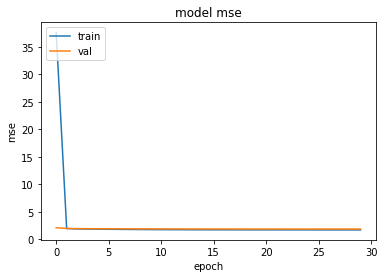

In [197]:
#plot training history
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# SVD (Surprise)

In [35]:
from surprise import SVD,SVDpp
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import KFold
from surprise.model_selection import GridSearchCV

In [ ]:
# split data as for deepFM, evaluate on the same test data
train, test = train_test_split(data, test_size=0.2,random_state=666)

In [42]:
# read in data for surprise
data_svd = train[['user_id','item_id','rating']]
reader = Reader(rating_scale=(0, 10)) # create reader object
# The columns must correspond to user id, item id and ratings (in that order).
data_svd = Dataset.load_from_df(data_svd[['user_id','item_id','rating']], reader)

In [43]:
# using grid search to fine tune hyper parameter
param_grid = {'n_factors':[3],'n_epochs': [10],'lr_all': [0.009],'reg_bu': [0.01],'reg_bi': [0.01],
              'reg_pu':[0.1],'reg_qi':[0.1],'init_mean':[0.001]} 
gs = GridSearchCV(SVD, param_grid, measures=['mse'], cv=5,refit=True)
gs.fit(data_svd)
print(gs.best_score['mse']) # best MSE score


#combination of parameters that gave the best MSE score
print('best params:',gs.best_params['mse'])
results_df = pd.DataFrame.from_dict(gs.cv_results)
results_df

1.9230167159453437
best params: {'n_factors': 3, 'n_epochs': 10, 'lr_all': 0.009, 'reg_bu': 0.01, 'reg_bi': 0.01, 'reg_pu': 0.1, 'reg_qi': 0.1, 'init_mean': 0.001}


,split0_test_mse,split1_test_mse,split2_test_mse,split3_test_mse,split4_test_mse,mean_test_mse,std_test_mse,rank_test_mse,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_n_factors,param_n_epochs,param_lr_all,param_reg_bu,param_reg_bi,param_reg_pu,param_reg_qi,param_init_mean
0,1.911606,1.941405,1.91543,1.915736,1.930906,1.923017,0.011324,1,1.583079,0.029237,0.389035,0.207204,"{'n_factors': 3, 'n_epochs': 10, 'lr_all': 0.0...",3,10,0.009,0.01,0.01,0.1,0.1,0.001


In [51]:
test_pred = []
for index, row in test.iterrows():
  u = row['user_id']
  i = row['item_id']
  cur_pred = gs.predict(int(u),int(i)).est
  test_pred.append(cur_pred)
mean_squared_error(test.rating, test_pred)